In [3]:
from datasets import load_dataset
# Load the CoNLL-2003 dataset
dataset = load_dataset("conll2003",trust_remote_code=True)
# Access the training, validation, and test sets
train_dataset = dataset['train']
validation_dataset = dataset['validation']
test_dataset = dataset['test']
# Example: Print the first example from the training set

C:\Users\adrib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Generating test split: 100%|██████████| 3453/3453 [00:00<00:00, 8507.64 examples/s]


### Fonctions

In [4]:
import string
import re
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
stemmer = PorterStemmer()


import nltk
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('maxent_ne_chunker_tab')
nltk.download('words')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# CONVERT ALL MAJUSCULES TO MINUSCULES
def text_lowercase(text):
    return text.lower()
# CONVERT FIRST LETTER IN MINUSCULES
def format_string(text):
    return re.sub(r'^\w', lambda m: m.group(0).lower(), text)


def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_whitespace(text):
    return  " ".join(text.split())

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    return filtered_text

# stem words in the list of tokenized words
def stem_words(text):
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    return stems

# Don't change the word with majuscule
def stem_words_conditional(sentence):
    words = sentence.split()  # Séparer en mots
    stemmed_words = [stemmer.stem(word) if not word[0].isupper() else word for word in words]
    return " ".join(stemmed_words)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\adrib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\adrib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\adrib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger_eng.zip.
[nltk_data] Downloading package maxent_ne_chunker_tab to
[nltk_data]     C:\Users\adrib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping chunkers\maxent_ne_chunker_tab.zip.
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\adrib\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\words.zip.


In [5]:
sentence_liste = [" ".join(sample['tokens']) for sample in train_dataset]
print(sentence_liste[30])

China on Thursday accused Taipei of spoiling the atmosphere for a resumption of talks across the Taiwan Strait with a visit to Ukraine by Taiwanese Vice President Lien Chan this week that infuriated Beijing .


In [6]:
first_clean = []
for sentence in sentence_liste:
    sentence = format_string(sentence)
    sentence = remove_punctuation(sentence)
    sentence = remove_numbers(sentence)
    sentence = remove_whitespace(sentence)
    sentence = remove_stopwords(sentence)
    
    first_clean.append(sentence)

print(len(first_clean))

# # delete empty sentences
# first_clean = [x for x in first_clean if x]

print(len(first_clean))

14041
14041


In [7]:
traited_sentences = []
second_clean = [" ".join(sample) for sample in first_clean]
for sentence in second_clean:
    sentence = stem_words_conditional(sentence)  # Appliquer le stemming conditionnel
    traited_sentences.append(sentence)

print(traited_sentences[30])


china Thursday accus Taipei spoil atmospher resumpt talk across Taiwan Strait visit Ukraine Taiwanese Vice President Lien Chan week infuri Beijing


In [8]:
# nltk.corpus.conll2002.fileids()

In [9]:
# train_sents = list(nltk.corpus.conll2002.iob_sents('esp.train'))
# test_sents = list(nltk.corpus.conll2002.iob_sents('esp.testb'))

In [10]:
# def word2features(sent, i):
#     word = sent[i][0]
#     postag = sent[i][1]

#     features = {
#         'bias': 1.0,
#         'word.lower()': word.lower(),
#         'word[-3:]': word[-3:],
#         'word[-2:]': word[-2:],
#         'word.isupper()': word.isupper(),
#         'word.istitle()': word.istitle(),
#         'word.isdigit()': word.isdigit(),
#         'postag': postag,
#         'postag[:2]': postag[:2],
#     }
#     if i > 0:
#         word1 = sent[i-1][0]
#         postag1 = sent[i-1][1]
#         features.update({
#             '-1:word.lower()': word1.lower(),
#             '-1:word.istitle()': word1.istitle(),
#             '-1:word.isupper()': word1.isupper(),
#             '-1:postag': postag1,
#             '-1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['BOS'] = True

#     if i < len(sent)-1:
#         word1 = sent[i+1][0]
#         postag1 = sent[i+1][1]
#         features.update({
#             '+1:word.lower()': word1.lower(),
#             '+1:word.istitle()': word1.istitle(),
#             '+1:word.isupper()': word1.isupper(),
#             '+1:postag': postag1,
#             '+1:postag[:2]': postag1[:2],
#         })
#     else:
#         features['EOS'] = True

#     return features


# def sent2features(sent):
#     return [word2features(sent, i) for i in range(len(sent))]

# def sent2labels(sent):
#     return [label for token, postag, label in sent]

# def sent2tokens(sent):
#     return [token for token, postag, label in sent]

In [11]:
# X_train = [sent2features(s) for s in train_sents]
# y_train = [sent2labels(s) for s in train_sents]

# X_test = [sent2features(s) for s in test_sents]
# y_test = [sent2labels(s) for s in test_sents]

In [12]:
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     c1=0.1,
#     c2=0.1,
#     max_iterations=100,
#     all_possible_transitions=True
# )
# crf.fit(X_train, y_train)

In [13]:
# labels = list(crf.classes_)
# labels.remove('O')
# labels

In [14]:
# y_pred = crf.predict(X_test)
# metrics.flat_f1_score(y_test, y_pred,
#                       average='weighted', labels=labels)

In [15]:
# sorted_labels = sorted(
#     labels,
#     key=lambda name: (name[1:], name[0])
# )
# print(metrics.flat_classification_report(
#     y_test, y_pred, labels=sorted_labels, digits=3
# ))

In [16]:
# import scipy.stats
# from sklearn.metrics import make_scorer
# from sklearn.model_selection import RandomizedSearchCV
# crf = sklearn_crfsuite.CRF(
#     algorithm='lbfgs',
#     max_iterations=100,
#     all_possible_transitions=True
# )
# params_space = {
#     'c1': scipy.stats.expon(scale=0.5),
#     'c2': scipy.stats.expon(scale=0.05),
# }

# # use the same metric for evaluation
# f1_scorer = make_scorer(metrics.flat_f1_score,
#                         average='weighted', labels=labels)

# # search
# rs = RandomizedSearchCV(crf, params_space,
#                         cv=3,
#                         verbose=1,
#                         n_jobs=-1,
#                         n_iter=50,
#                         scoring=f1_scorer)
# rs.fit(X_train, y_train)

In [17]:
# print('best params:', rs.best_params_)
# print('best CV score:', rs.best_score_)
# print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

In [18]:
import spacy 
# Load spaCy's pre-trained NER model 
nlp = spacy.load("./en_ner_conll03/best_ner_model") 

# Example text 
text = "The firm Apple was founded by Steve Jobs." 
# Process the text with spaCy 
doc = nlp(text) 
# Extract named entities 
entities = [(ent.text, ent.label_) for ent in doc.ents] 
print(entities) 

C:\Users\adrib\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_pipeline' (0.0.0) was trained with spaCy v3.7.5 and may not be 100% compatible with the current version (3.8.5). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


[('Apple', 'ORG'), ('Steve Jobs', 'PER')]


In [19]:
traited_sentences[25]

'buyer also snap item put auction Hendrix former girlfriend Kathy Etchingham live'

In [20]:
" ".join(train_dataset[25]['tokens']) 

"Buyers also snapped up 16 other items that were put up for auction by Hendrix 's former girlfriend Kathy Etchingham , who lived with him from 1966 to 1969 ."

In [21]:
sent_tra=traited_sentences[30]
sent=" ".join(train_dataset[30]['tokens']) 
doc_tra=nlp(sent_tra)
doc=nlp(sent)
print([(ent.text, ent.label_) for ent in doc_tra.ents])
print([(ent.text, ent.label_) for ent in doc.ents])


[('Taipei', 'LOC'), ('Taiwan Strait', 'LOC'), ('Ukraine Taiwanese', 'ORG'), ('Lien Chan', 'PER'), ('Beijing', 'LOC')]
[('China', 'LOC'), ('Taipei', 'LOC'), ('Taiwan Strait', 'LOC'), ('Ukraine', 'LOC'), ('Taiwanese', 'MISC'), ('Lien Chan', 'PER'), ('Beijing', 'LOC')]


In [22]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

ex = 'European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices'

def preprocess(sent):
    sent = nltk.word_tokenize(sent)
    sent = nltk.pos_tag(sent)
    return sent

sent = preprocess(ex)
sent

[('European', 'JJ'),
 ('authorities', 'NNS'),
 ('fined', 'VBD'),
 ('Google', 'NNP'),
 ('a', 'DT'),
 ('record', 'NN'),
 ('$', '$'),
 ('5.1', 'CD'),
 ('billion', 'CD'),
 ('on', 'IN'),
 ('Wednesday', 'NNP'),
 ('for', 'IN'),
 ('abusing', 'VBG'),
 ('its', 'PRP$'),
 ('power', 'NN'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('mobile', 'JJ'),
 ('phone', 'NN'),
 ('market', 'NN'),
 ('and', 'CC'),
 ('ordered', 'VBD'),
 ('the', 'DT'),
 ('company', 'NN'),
 ('to', 'TO'),
 ('alter', 'VB'),
 ('its', 'PRP$'),
 ('practices', 'NNS')]

In [23]:
pattern = 'NP: {<DT>?<JJ>*<NN>}'
cp = nltk.RegexpParser(pattern)
cs = cp.parse(sent)
print(cs)

(S
  European/JJ
  authorities/NNS
  fined/VBD
  Google/NNP
  (NP a/DT record/NN)
  $/$
  5.1/CD
  billion/CD
  on/IN
  Wednesday/NNP
  for/IN
  abusing/VBG
  its/PRP$
  (NP power/NN)
  in/IN
  (NP the/DT mobile/JJ phone/NN)
  (NP market/NN)
  and/CC
  ordered/VBD
  (NP the/DT company/NN)
  to/TO
  alter/VB
  its/PRP$
  practices/NNS)


In [24]:
from nltk.chunk import conlltags2tree, tree2conlltags
from pprint import pprint
iob_tagged = tree2conlltags(cs)
pprint(iob_tagged)

[('European', 'JJ', 'O'),
 ('authorities', 'NNS', 'O'),
 ('fined', 'VBD', 'O'),
 ('Google', 'NNP', 'O'),
 ('a', 'DT', 'B-NP'),
 ('record', 'NN', 'I-NP'),
 ('$', '$', 'O'),
 ('5.1', 'CD', 'O'),
 ('billion', 'CD', 'O'),
 ('on', 'IN', 'O'),
 ('Wednesday', 'NNP', 'O'),
 ('for', 'IN', 'O'),
 ('abusing', 'VBG', 'O'),
 ('its', 'PRP$', 'O'),
 ('power', 'NN', 'B-NP'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'B-NP'),
 ('mobile', 'JJ', 'I-NP'),
 ('phone', 'NN', 'I-NP'),
 ('market', 'NN', 'B-NP'),
 ('and', 'CC', 'O'),
 ('ordered', 'VBD', 'O'),
 ('the', 'DT', 'B-NP'),
 ('company', 'NN', 'I-NP'),
 ('to', 'TO', 'O'),
 ('alter', 'VB', 'O'),
 ('its', 'PRP$', 'O'),
 ('practices', 'NNS', 'O')]


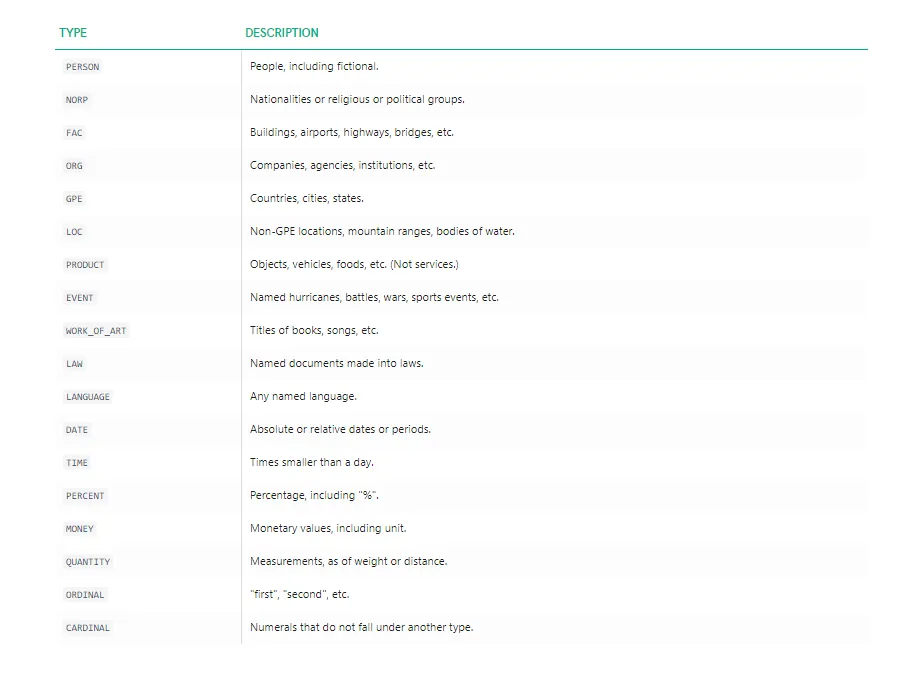

In [25]:
# ne_tree = nltk.ne_chunk((pos_tag(word_tokenize(ex))))
# print(ne_tree)

In [26]:
doc = nlp('European authorities fined Google a record $5.1 billion on Wednesday for abusing its power in the mobile phone market and ordered the company to alter its practices')
pprint([(X.text, X.label_) for X in doc.ents])

[('European', 'MISC'), ('Google', 'PER')]


In [27]:
from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))
ny_bb = url_to_string('https://huggingface.co/learn/nlp-course/chapter1/1?fw=pt')
article = nlp(ny_bb)
len(article.ents)

151

In [28]:
from collections import Counter

print(article.ents)
items = [x.text for x in article.ents]
Counter(items).most_common(3)

(Sign Up, Introduction LLM Course, View, CourseML, 3D, CNZH, TW, Introduction Natural Language Processing, Large Language Models Transformers, Bias, NLP, Large Language Models, Build Reasoning Models, Events Join, Hugging Face, Spaces Faster, Switch, Sign Up, Introduction, LLMs, NLP, Hugging Face, Hugging Face Hub, NLP, LLMs While, NLP, Large Language Models, LLMs, NLP, NLP, LLMs, Large Language Models, NLP, Llama, GPT, Claude, LLMs, NLP, NLP, LLM, NLP, LLMs, Chapters, 🤗 Transformers, Transformer, Hugging Face Hub, Hub, Chapters, 🤗 Datasets, NLP, LLM, Chapter, NLP, Hub, Chapters, LLM, Requires, Python Is, Coders, AI Does, PyTorch, TensorFlow, AI, NLP, Bayes, LSTMs, Abubakar Abid, PhD, Stanford, PhD, Gradio, Python, Gradio, Hugging Face, Abubakar, Ben Burtenshaw, Machine Learning Engineer, Hugging Face, PhD, Natural Language Processing, University of Antwerp, Transformer, Matthew Carrigan, Machine Learning Engineer, Hugging Face, Dublin, Ireland, ML, Parse.ly, Trinity College Dublin, AG

[('NLP', 16), ('Hugging Face', 15), ('LLMs', 6)]

In [29]:
from spacy import displacy
displacy.render(nlp(str(traited_sentences[31])), jupyter=True, style='ent')


In [30]:
import spacy 
# python -m spacy download en_core_web_sm

nlp = spacy.load("en_core_web_sm") 

displacy.render(nlp(str(sentence_liste[31])), style='dep', jupyter = True, options = {'distance': 120})

In [31]:
sentence_liste[31]

'Speaking only hours after Chinese state media said the time was right to engage in political talks with Taiwan , Foreign Ministry spokesman Shen Guofang told Reuters : " The necessary atmosphere for the opening of the talks has been disrupted by the Taiwan authorities . "'

In [32]:
# Load spaCy's pre-trained model 
nlp = spacy.load("en_core_web_sm") 
# Example text 
text = "Apple was founded by Steve Jobs." 
# Process the text with spaCy 
doc = nlp(text) 
# Extract relations 
relations = [] 
for token in doc: 
    print(token.text, token.dep_, token.head.text)
    if (token.dep_ == "nsubj" or token.dep_ == "nsubjpass") and  token.head.dep_ == "ROOT": 
        subject = token.text 
        predicate = token.head.text 
        for child in token.head.children: 
            if child.dep_ == "prep" or child.dep_ == "agent": 
                for obj in child.children: 
                    if obj.dep_ == "pobj": 
                                            relations.append((subject, predicate, obj.text)) 
print(relations) 

Apple nsubjpass founded
was auxpass founded
founded ROOT founded
by agent founded
Steve compound Jobs
Jobs pobj by
. punct founded
[('Apple', 'founded', 'Jobs')]


In [33]:
from rdflib import Graph, URIRef, Literal, Namespace 
from rdflib.namespace import RDF, RDFS
g = Graph() 
EX = Namespace("http://example.org/") 

g.add((URIRef(EX.Apple), RDF.type, URIRef(EX.Company))) 
g.add((URIRef(EX.SteveJobs), RDF.type, URIRef(EX.Person))) 
g.add((URIRef(EX.Apple), URIRef(EX.founded_by), URIRef(EX.SteveJobs))) 
# Serialize the graph in RDF/XML format 
print(g.serialize(format="xml"))


<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ns1="http://example.org/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <rdf:Description rdf:about="http://example.org/SteveJobs">
    <rdf:type rdf:resource="http://example.org/Person"/>
  </rdf:Description>
  <rdf:Description rdf:about="http://example.org/Apple">
    <rdf:type rdf:resource="http://example.org/Company"/>
    <ns1:founded_by rdf:resource="http://example.org/SteveJobs"/>
  </rdf:Description>
</rdf:RDF>



In [34]:
query = """ 
SELECT ?subject ?predicate 
WHERE { 
  ?subject ?predicate <http://example.org/SteveJobs> 
} 
"""
for row in g.query(query): 
    print(f"{row.subject} {row.predicate}  ")

http://example.org/Apple http://example.org/founded_by  


In [36]:
from selenium import webdriver 
from selenium.webdriver.chrome.options import Options 
from bs4 import BeautifulSoup 
def fetch_reuters_articles(): 
    # Configure Chrome options for headless browsing (optional) 
    chrome_options = Options() 
    #chrome_options.add_argument("--headless")  # Run Chrome in headless 
    chrome_options.add_argument("--no-sandbox")  # Bypass OS security 
    chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome 
    # Initialize the Chrome webdriver 
    driver = webdriver.Chrome(options=chrome_options) 
    # URL of Reuters World section 
    url = "https://www.reuters.com/world/" 
    # Load the page using Selenium 
    driver.get(url) 
    # Get the page source after JavaScript execution 
    page_source = driver.page_source 
    # Close the browser 
    driver.quit() 
    # Parse the HTML content with BeautifulSoup 
    articles = []
    soup = BeautifulSoup(page_source, "html.parser") 
    for article in soup.find_all('article', limit=10): 
        title = article.find('h3').get_text() 
        link = article.find('a')['href'] 
        article_url = f"https://www.reuters.com{link}" 
        article_response = requests.get(article_url) 
        article_soup = BeautifulSoup(article_response.content, 'html.parser') 
        content = article_soup.find('div', class_='StandardArticleBody_body').get_text() 
        publication_date = article_soup.find('meta', {'name': 'article:published_time'})['content'] 
        articles.append({ 
        'title': title, 
        'url': article_url, 
        'content': content, 
        'publication_date': publication_date 
                }) 
    return articles 
articles = fetch_reuters_articles() 
for article in articles: 
    print(article['title'], article['publication_date']) 
    print(article['content'][:200])  # Print the first 200 characters of 
    # content
    print()

In [ ]:
from selenium.webdriver.common.by import By
import time
# Configure Chrome options for headless browsing (optional) 
chrome_options = Options() 
#chrome_options.add_argument("--headless")  # Run Chrome in headless 
chrome_options.add_argument("--no-sandbox")  # Bypass OS security 
chrome_options.add_argument("--disable-dev-shm-usage")  # Overcome 
# Initialize the Chrome webdriver 
driver = webdriver.Chrome(options=chrome_options) 
# URL of Reuters World section 
url = "https://www.reuters.com/world/" 
# Load the page using Selenium 
driver.get(url) 
time.sleep(0.5)  # Wait for the page to load
driver.find_element(By.CSS_SELECTOR,"#onetrust-reject-all-handler").click()

# the web site detect a robot, so it isn't possible to scrape the data with selenium.


# TD4

## Scarping wikipedia

### found articles

In [180]:
import requests

def rechercher_articles_wikipedia(mot_cle, nombre_resultats=10):
    url = "https://en.wikipedia.org/w/api.php"

    params = {
        "action": "query",
        "list": "search",
        "srsearch": mot_cle,
        "format": "json",
        "srlimit": nombre_resultats,
    }

    response = requests.get(url, params=params)
    data = response.json()

    articles = []
    for result in data["query"]["search"]:
        titre = result["title"]
        lien = f"https://en.wikipedia.org/wiki/{titre.replace(' ', '_')}"
        articles.append((titre, lien))

    return articles

# Exemple d'utilisation
mot_cle = "Seconde Guerre mondiale"
articles = rechercher_articles_wikipedia(mot_cle)

# adding better results
articles= articles[:-1]
articles.append(("Seconde Guerre mondiale", "https://en.wikipedia.org/wiki/World_War_II"))

### extracting the text form articles

In [181]:
from bs4 import BeautifulSoup
import requests
import re
def url_to_string(url):
    res = requests.get(url)
    html = res.text
    soup = BeautifulSoup(html, "lxml")
    for script in soup(["script", "style", 'aside']):
        script.extract()
    return " ".join(re.split(r'[\n\t]+', soup.get_text()))

wiki_articles=[]
for titre, lien in articles:
    print(titre)
    print(lien)
    wiki_articles.append(url_to_string(lien))

# TEST
ny_bb = url_to_string('https://en.wikipedia.org/wiki/Belgium_in_World_War_II')



German occupation of Belgium during World War II
https://en.wikipedia.org/wiki/German_occupation_of_Belgium_during_World_War_II
List of last surviving World War II veterans
https://en.wikipedia.org/wiki/List_of_last_surviving_World_War_II_veterans
French West Africa in World War II
https://en.wikipedia.org/wiki/French_West_Africa_in_World_War_II
Art and World War II
https://en.wikipedia.org/wiki/Art_and_World_War_II
Filthy Thirteen
https://en.wikipedia.org/wiki/Filthy_Thirteen
Apostolic Nunciature to the Philippines
https://en.wikipedia.org/wiki/Apostolic_Nunciature_to_the_Philippines
Bombing of Rome in World War II
https://en.wikipedia.org/wiki/Bombing_of_Rome_in_World_War_II
Actes et documents du Saint Siège relatifs à la Seconde Guerre Mondiale
https://en.wikipedia.org/wiki/Actes_et_documents_du_Saint_Siège_relatifs_à_la_Seconde_Guerre_Mondiale
Japanese occupation of Cambodia
https://en.wikipedia.org/wiki/Japanese_occupation_of_Cambodia
Seconde Guerre mondiale
https://en.wikipedia.o

## Preprocessing the text

### removing part that we don't need 

In [182]:
def remove_after_notes(text):
    # removing everything after "Notes", "References", or "See also" sections
    pattern = r"(notes\s*\[edit\]|references\s*\[edit\]|see also\s*\[edit\])"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return text[:match.start()].strip()
    return text

def remove_before(text):
    pattern = r"from wikipedia, the free encyclopedia"
    match = re.search(pattern, text, re.IGNORECASE)
    if match:
        return text[match.end():].strip()
    return text

### suprimer les chiffre reference et les edit 

In [ ]:
def remove_wiki_number(text):
    sentence_wiki=text.split('.')
    traite_wiki_sen=[]
    final=[]
    regex = re.compile(r'\[(\d+)\]')
    for i in range(len(sentence_wiki)):
        traite_wiki_sen.append(regex.sub('', sentence_wiki[i]))

    return '. '.join(traite_wiki_sen)


# suprime moi tout les mot qui ont [a-x]+[edit] dedans
def remove_edit(text):
    pattern = r'\b\w+\[edit\]'
    return re.sub(pattern, "", text)


'Belgium in World War II '

In [193]:
print(len(ny_bb))
new=remove_after_notes(ny_bb)
print(len(new))
new=remove_before(new)
print(len(new))
new=remove_wiki_number(new)
print(len(new))
new=remove_edit(new)
print(len(new))


64620
32859
31315
30918
30712


In [194]:

article = nlp(new)
print(len(article.ents))
print(article.ents)

777
(German, the Royal Palace, Brussels, 1940, World War II, Belgium, German, 10 May 1940, 18 days, Belgian, Belgian, Germans, 1944, 28 May, King Leopold III, Belgians, the United Kingdom, Allied, The Belgian Congo, Belgian, London, Allied, Belgians, German, German, Belgian, German, two, Waffen-SS, Belgium, Nazi, Belgian, Jews, nearly 25,000, between September and October 1944, early 1945, approximately 88,000, Belgians, 1, 05 percent, around 8 percent, the 1930s, Belgium, World War I.  Economically, Belgium, the Great Depression of 1929, 1932, 23, 5 percent, around 15 percent, 1937, The 1930s, Wallonia, 1936, one, the Rexist party, 11, 6 percent, 1939, the K-W Line, the River Dijle, late 1939, Belgium, World War I, European, October 1936, Belgium, Europe, Independent Policy, Belgian, the Locarno Treaty, France, 1920, Nazi Germany, 1937, The German Government, Belgium, Belgian, German, 13 October 1937, Belgian, Liège Province, German, the United Kingdom, France, Germany, September 1939

In [ ]:
def extract_relations(doc):
    relations = [] 
    RELEVANT_PREPOSITIONS = {"to", "by", "with", "for", "in", "on"}

    for token in doc: 

        if (token.dep_ == "nsubj" or token.dep_ == "nsubjpass") and  token.head.dep_ == "ROOT": 
            #print(token.text, token.dep_, token.head.text)
            subject = token.text 
            predicate = token.head.text 
            for child in token.head.children: 
                if (child.dep_ == "prep" or child.dep_ == "agent") and child.text.lower() in RELEVANT_PREPOSITIONS: 
                    for obj in child.children: 
                        if obj.dep_ == "pobj": 
                                                relations.append((subject, predicate, obj.text)) 
    return relations

In [200]:
wiki_sentences = new.split('.')
print(wiki_sentences[1])

  After 18 days of fighting in which Belgian forces were pushed back into a small pocket in the north-west of the country, the Belgian military surrendered to the Germans, beginning an occupation that would endure until 1944


In [201]:


for i in range(len(wiki_sentences)):
    doc = nlp(wiki_sentences[i])
    relations = extract_relations(doc)
    print(f"Relations in sentence {i}:")
    for relation in relations:
        print(relation)

Relations in sentence 0:
('soldiers', 'parade', 'Palace')
Relations in sentence 1:
('military', 'surrendered', 'days')
('military', 'surrendered', 'Germans')
('military', 'surrendered', 'occupation')
Relations in sentence 2:
('surrender', 'ordered', 'III')
('surrender', 'ordered', 'consultation')
Relations in sentence 3:
('Belgians', 'managed', 'capitulation')
Relations in sentence 4:
Relations in sentence 5:
('Belgians', 'involved', 'resistance')
Relations in sentence 6:
Relations in sentence 7:
('Most', 'liberated', 'Allies')
('Most', 'liberated', 'September')
Relations in sentence 8:
('Belgians', 'died', 'total')
('Belgians', 'died', 'conflict')
Relations in sentence 9:
Relations in sentence 10:
('Belgium', 'recovering', '1930s')
('Belgium', 'recovering', 'destruction')
Relations in sentence 11:
('Belgium', 'experiencing', 'aftermath')
Relations in sentence 12:
('this', 'reduced', 'percent')
('this', 'reduced', '1937')
Relations in sentence 13:
Relations in sentence 14:
('one', 'gai

In [175]:
# Load spaCy's pre-trained model 
nlp = spacy.load("en_core_web_sm") 
# Example text 
text = "Apple was founded by Steve Jobs." 
text=wiki_sentences[5]
# Process the text with spaCy 
doc = nlp(text) 
# Extract relations  
extract_relations(doc)

[('Belgians', 'involved', 'resistance')]

In [164]:
from rdflib import Graph, URIRef, Literal, Namespace 
from rdflib.namespace import RDF, RDFS 
# Create a new RDF graph 
g = Graph() 
# Define namespaces 
EX = Namespace("http://example.org/") 
# Add triples to the graph 
g.add((URIRef(EX.Apple), RDF.type, URIRef(EX.Company))) 
g.add((URIRef(EX.SteveJobs), RDF.type, URIRef(EX.Person))) 
g.add((URIRef(EX.Apple), URIRef(EX.founded_by), URIRef(EX.SteveJobs))) 
# Serialize the graph in RDF/XML format 
print(g.serialize(format="xml")) 
# Perform a SPARQL query 
query = """ 
SELECT ?subject ?predicate 
WHERE { 
  ?subject ?predicate <http://example.org/SteveJobs> 
} 
"""
for row in g.query(query): 
    print(f"{row.subject} {row.predicate} ")

<?xml version="1.0" encoding="utf-8"?>
<rdf:RDF
   xmlns:ns1="http://example.org/"
   xmlns:rdf="http://www.w3.org/1999/02/22-rdf-syntax-ns#"
>
  <rdf:Description rdf:about="http://example.org/SteveJobs">
    <rdf:type rdf:resource="http://example.org/Person"/>
  </rdf:Description>
  <rdf:Description rdf:about="http://example.org/Apple">
    <rdf:type rdf:resource="http://example.org/Company"/>
    <ns1:founded_by rdf:resource="http://example.org/SteveJobs"/>
  </rdf:Description>
</rdf:RDF>

http://example.org/Apple http://example.org/founded_by 
